In [1]:
import os
import requests
from typing import Annotated, Literal
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field 
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from API.booking import BookingAPI
from API.geoCoding import GeoCodingAPI
from API.getKey import OAuthClient
from API.getQuotes import QuotesAPI
from API.is_Airport import IsAirport

from langgraph.graph import StateGraph, MessagesState, START, END
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'

class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride.This is optional if provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user.This is optional if provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name.This is optional if provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name.This is optional if provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time..This is optional if provided"
    )
    # @feild_validator('')


def check_what_is_empty(user_personal_details):
    ask_for = []
    # Check if fields are empty
    for field, value in user_personal_details.model_dump().items():
        if value in [None, "", 0]:  # Add other 'empty' conditions if needed
            print(f"Field '{field}' is empty.")
            ask_for.append(field)
    return ask_for

def add_non_empty_details(current_details: BookingCarDetails, new_details: BookingCarDetails):
    non_empty_details = {k: v for k, v in new_details.model_dump().items() if v not in [None, ""]}
    updated_details = current_details.model_copy(update=non_empty_details)
    return updated_details

def ask_for_info(ask_list: list):
    first_prompt = ChatPromptTemplate.from_template(
        """Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. 
        Explain you're gathering info to help. If 'ask_for' is empty, thank the user and ask how you can assist next.
        ### ask_for list: {ask_for}"""
    )
    info_gathering_chain = first_prompt | llm | StrOutputParser()
    ai_chat = info_gathering_chain.invoke({"ask_for": ask_list})
    print(first_prompt)
    return ai_chat
def filter_response(text_input, user_details ):
    chain = llm.with_structured_output(BookingCarDetails)
    res = chain.invoke(text_input)
    # add filtered info to the
    user_details = add_non_empty_details(user_details,res)
    print(user_details)
    ask_for = check_what_is_empty(user_details)
    return user_details, ask_for
def ask_confirm_info(booking_details: BookingCarDetails):
    # booking_details.
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)


In [2]:
class State(MessagesState):
    messages : str

In [3]:
@tool
def get_booking_details(state : State):
    """ Call function to get the details for a booking from user"""
    chain = llm.with_structured_output(BookingCarDetails)
    response =chain.invoke(state["messages"][-1])
    booking_details = BookingCarDetails(
        name="", number_phone="", pick_up_location="", destination_location="", pick_up_time=""
    )
    booking_details = add_non_empty_details(booking_details, response)
    ask_for = check_what_is_empty(booking_details)
    ai_response = ask_for_info(ask_for)
    print(ai_response)
    text_input = input()
    user_details, ask_for = filter_response(text_input, booking_details)
    while ask_for:  
        ai_response = ask_for_info(ask_for)
        input
        print(ai_response)
        text_input = input()
        user_details, ask_for = filter_response(text_input, user_details)
        print(ask_for)
    return user_details

In [4]:
@tool
def get_quotes(booking_details : BookingCarDetails):
    """Call function to fetches quotes for car bookings based on the provided booking details."""
    quotesAPI = QuotesAPI(os.getenv("JUPITER_API") + "/demand/v1/quotes")
    geoCodingAPI = GeoCodingAPI()
    print("GeoCoding API")
    # geoCoding_destination =
    geoCoding_pickup =  geoCodingAPI.get_geocoding(booking_details.pick_up_location)
    geoCoding_destination = geoCodingAPI.get_geocoding(booking_details.destination_location)
    
    # input_datetime = datetime.fromisoformat(pick_up_time)
    pickup_datetime = "2025-01-18T09:24:10.000Z"
    
    pickup_coords = { "latitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_pickup['results'][0]['geometry']['location']['lng']),}
    destination_coords = { "latitude": float(geoCoding_destination['results'][0]['geometry']['location']['lat']),"longitude": float(geoCoding_destination['results'][0]['geometry']['location']['lng']),}
    quotes_data = quotesAPI.get_quotes(pickup_datetime, pickup_coords, destination_coords)
    return quotes_data

In [5]:
@tool
def ask_confirm(state: MessagesState, booking_details : BookingCarDetails):
    """Prompts the user to confirm the booking details. """
    message = (
        f"Please confirm your ride details:\n"
        f"- Pickup Location: {booking_details.pick_up_location}\n"
        f"- Destination: {booking_details.destination_location}\n"
        f"- Pickup Time: {booking_details.pick_up_time}\n"
        f"- Name: {booking_details.name}\n"
        f"- Contact Number: {booking_details.number_phone}\n"
    )
    print(message)
    return 

In [6]:
tools = [get_booking_details,ask_confirm,get_quotes]  
# config = {"configurable": {"thread_id": "1"}}

In [7]:
config = {"configurable": {"thread_id": "1"}}
    
    # graph_builder = StateGraph(State)
    

system_prompt = """
    You are a very powerful assistant. Be polite, clear, and understandable.
    If users ask general questions, answer them helpfully. 
    """
agent_executor = create_react_agent(llm, tools = tools, state_modifier=system_prompt)
inputs = {"messages": []}  # Khởi tạo danh sách messages

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Exiting the chatbot. Goodbye!")
        break
    inputs["messages"].append(("user", user_input))
    for s in agent_executor.stream(inputs, stream_mode="values"):
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(f"Assistant: {message[1]}")
        else:
            message.pretty_print()

================================ Human Message =================================

i want to book a car
================================== Ai Message ==================================

I can help you with that! Please provide me with the following details for your car booking:

1. Your name (optional)
2. Your phone number (optional)
3. Pick-up location
4. Destination location
5. Pick-up time

Once I have this information, I can assist you further!
================================ Human Message =================================

name Huy
================================== Ai Message ==================================

Could you please provide me with the following details to complete your car booking?

1. Your phone number (optional).
2. The pick-up location.
3. The destination location.
4. The time you intend to be picked up. 

Once I have this information, I can assist you further!
================================ Human Message =================================

09171818880
==========

KeyboardInterrupt: Interrupted by user

In [8]:
tools = [get_booking_details]  
config = {"configurable": {"thread_id": "1"}}
    
# graph_builder = StateGraph(State)

system_prompt = """
    You are a very powerful assistant. Be polite, clear, and understandable.
    If users ask general questions, answer them helpfully. 
    If users want to book a ride, call the 'get_booking_details' function to gather booking information.
    Please confirm information after done 'get_booking_details' .
    If user confirm, call the 'get_quotes' ,else thank you user
    
    """
agent_executor = create_react_agent(llm, tools = tools, state_modifier=system_prompt )
inputs = {"messages": []}  # Khởi tạo danh sách messages

while True:
    user_input = input("You: ")
    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Exiting the chatbot. Goodbye!")
        break
    inputs["messages"].append(("user", user_input))
    for s in agent_executor.stream(inputs, stream_mode="values"):
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(f"Assistant: {message[1]}")
        else:
            message.pretty_print()

================================ Human Message =================================

my name is Huy book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow . call me 09171881800
================================== Ai Message ==================================
Tool Calls:
  get_booking_details (call_kOYg6w9uN9aeWMLymvs4VRat)
 Call ID: call_kOYg6w9uN9aeWMLymvs4VRat
  Args:
    state: {'messages': 'Book a car to 271 Nguyen Van Linh, Da Nang from 460 Tran Dai Nghia, Da Nang at 9 tomorrow. Call me 09171881800.'}
input_variables=['ask_for'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['ask_for'], input_types={}, partial_variables={}, template="Ask one question at a time, even if you don't get all the info. Don't list the questions or greet the user. \n        Explain you're gathering info to help. If 'ask_for' is empty, thank the user and ask how you can assist next.\n        ### ask_for list: {a

KeyboardInterrupt: 

In [11]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}

In [23]:
workflow = StateGraph(MessagesState)
tools = [get_booking_details]   
tool_getinfo = ToolNode(tools)

tool_confirm = ToolNode([confirm])

tool_getquotes = ToolNode([get_quotes])

workflow.add_node("agent", call_model)
workflow.add_node("get_info", tool_getinfo)
workflow.add_node("ask_confirm",tool_confirm)
workflow.add_node("get_quotes",tool_getquotes)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "get_info")
workflow.add_edge("get_info", "ask_confirm")
workflow.add_edge("ask_confirm", "get_quotes")
# workflow.add_edge("get_info", "agent")
# checkpointer = MemorySaver()
app = workflow.compile()
# app = workflow.compile()

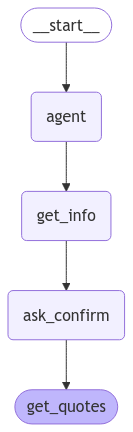

In [24]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [26]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "hi")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello! How can I assist you today?
================================== Ai Message ==================================

Hello! How can I assist you today?
================================== Ai Message ==================================

Hello! How can I assist you today?
================================== Ai Message ==================================

Hello! How can I assist you today?


In [27]:
for chunk in app.stream(
    {"messages": [("human", "i want to book a car")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

i want to book a car
================================== Ai Message ==================================

Sure! To help you book a car, I need a bit more information:

1. **Location**: Where do you want to pick up the car?
2. **Dates**: What are the start and end dates for your rental?
3. **Car Type**: Do you have a specific type of car in mind (e.g., economy, SUV, luxury)?
4. **Rental Company**: Do you have a preferred rental company, or are you open to suggestions?
5. **Additional Requirements**: Any other preferences or requirements (e.g., GPS, child seat)?

Once I have this information, I can guide you on how to proceed!
================================== Ai Message ==================================

Sure! To help you book a car, I need a bit more information:

1. **Location**: Where do you want to pick up the car?
2. **Dates**: What are the start and end dates for your rental?
3. **Car Type**: Do you h

In [ ]:
import uuid

cached_human_responses = ["hi!", "rag prompt", "1 rag, 2 none, 3 no, 4 no", "red", "q"]
cached_response_index = 0
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        user = cached_human_responses[cached_response_index]
        cached_response_index += 1
    print(f"User (q/Q to quit): {user}")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    if output and "prompt" in output:
        print("Done!")

In [4]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



class State(MessagesState):
    next: str


def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [60]:
import os
import requests
from typing import Annotated, Literal , List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field , field_validator
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt
from langgraph.graph.message import AnyMessage
from API.booking import BookingAPI
from API.geoCoding import GeoCodingAPI
from API.getKey import OAuthClient
from API.getQuotes import QuotesAPI
from API.is_Airport import IsAirport

from langgraph.graph import StateGraph, MessagesState, START, END

llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")
jupiterAPI = os.getenv('JUPITER_API')
quoteAPI = str(jupiterAPI) + "/demand/v1/quotes"
bookingsAPI  = str(jupiterAPI) + '/demand/v1/bookings'

class BookingCarDetails(BaseModel):
    """Details for the bookings car details"""
    name: str = Field(
        ...,
        description="The name of the person booking the ride.This is optional if provided",
    )
    number_phone: str = Field(
        ...,
        description="The phone number of the user.This is optional if provided",
    )
    pick_up_location: str = Field(
        ...,
        description="The location where the user will be picked up. This can be a full address or a specific location name.This is optional if provided",
    )
    destination_location: str = Field(
        ...,
        description="The destination location for the ride. This can be a full address or a specific location name.This is optional if provided"
    )
    pick_up_time: str = Field(
        ...,
        description="The time the user intends to be picked up. No format keeps the text related to time..This is optional if provided"
    )
    @field_validator('pick_up_location')
    @classmethod
    def validate_pickup(cls, value:str):
        geoCodingAPI = GeoCodingAPI()
        geoCoding_pickup = geoCodingAPI.get_geocoding(value)
        if geoCoding_pickup["status"] == "OK" :
            return geoCoding_pickup['results'][0]['formatted_address']
        else:
            raise ValueError(f"Invalid pick-up location: {value}")
    @field_validator('pick_up_location','destination_location',mode= "before")
    @classmethod
    def validate_destination(cls, value: List[str]):
        geoCodingAPI = GeoCodingAPI()
        print(value.)
        geoCoding_destination = geoCodingAPI.get_geocoding(value[1])
        
        if geoCoding_destination["status"] == "OK":
            if geoCoding_destination['results'][0]['formatted_address'] == value[0]:
                raise ValueError(f"Invalid destination location: {value}")
            else:
                return {"destination_result": geoCoding_destination}
                
        else:
            raise ValueError(f"Invalid destination location: {value}")

In [61]:
BookingCarDetails(name="hUY",number_phone="",pick_up_location="271 Nguyen Van Linh, Da Nang", destination_location="01 Nguyen Van Linh, Da Nang", pick_up_time="now")

2
0


ValidationError: 2 validation errors for BookingCarDetails
pick_up_location
  Value error, Invalid destination location: 271 Nguyen Van Linh, Da Nang [type=value_error, input_value='271 Nguyen Van Linh, Da Nang', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/value_error
destination_location
  Value error, Invalid destination location: 01 Nguyen Van Linh, Da Nang [type=value_error, input_value='01 Nguyen Van Linh, Da Nang', input_type=str]
    For further information visit https://errors.pydantic.dev/2.7/v/value_error

In [36]:
geoCodingAPI = GeoCodingAPI()
geoCoding_pickup = geoCodingAPI.get_geocoding("271 Nguyen Van Linh")
print(geoCoding_pickup)

{'results': [{'address_components': [{'long_name': 'Đường Nguyễn Văn Linh', 'short_name': 'Đ. Nguyễn Văn Linh', 'types': ['route']}, {'long_name': 'Hồ Chí Minh', 'short_name': 'Hồ Chí Minh', 'types': ['administrative_area_level_1', 'political']}, {'long_name': 'Vietnam', 'short_name': 'VN', 'types': ['country', 'political']}], 'formatted_address': 'Đ. Nguyễn Văn Linh, Hồ Chí Minh, Vietnam', 'geometry': {'bounds': {'northeast': {'lat': 10.7551966, 'lng': 106.7293611}, 'southwest': {'lat': 10.6854518, 'lng': 106.5937658}}, 'location': {'lat': 10.7228245, 'lng': 106.6606769}, 'location_type': 'GEOMETRIC_CENTER', 'viewport': {'northeast': {'lat': 10.7551966, 'lng': 106.7293611}, 'southwest': {'lat': 10.6854518, 'lng': 106.5937658}}}, 'partial_match': True, 'place_id': 'ChIJCbhL7IAvdTERuiMumGb1LMY', 'types': ['route']}], 'status': 'OK'}
